In [ ]:
# Code to augment Y-M relation and reduce scatter in it

In [1]:
import numpy as np
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt, amin, amax, mean, dot, power
import h5py, os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import scipy, time, multiprocessing
from scipy import interpolate
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
# for aesthetic plots
font = {'size'   : 14, 'family':'STIXGeneral'}
matplotlib.rc('font', **font)
matplotlib.rc('axes', labelsize=18) 
matplotlib.mathtext.rcParams['legend.fontsize']=14
plt.rcParams["figure.figsize"] = [6.0,4.]
plt.rcParams["xtick.labelsize"] = 16; plt.rcParams["ytick.labelsize"] = 16
matplotlib.rc('text', usetex=True)

In [13]:
# Download data files from https://drive.google.com/drive/folders/1lDG-jtQjpGAh7QAEQ4KYKrY8Iu3Y6h-H?usp=sharing

dire='/Users/jayw/Documents/Acad/CCA/data/SZ/' # Set directory
os.chdir(dire+'z=0.0')

In [14]:
XH=0.76; # H mass fraction

# Scaling Y from Leander's files
# 1e-6 * sigma_T / (me * c^2) * 1e10msun/h / Gyr^2
Yscale= 1e-6 * (6.65e-25) / (9.1e-28 * 3e10**2) * 1.989e43/0.6774 / (3.154e16)**2

In [15]:
# IllustrisTNG300 data at z=0 (https://www.tng-project.org/data/docs/specifications/#sec2a)

Y = np.load('Y_200c.npy') #Scale with 'Yscale' to get [Mpc^2] units
m200 = np.load('Group_M_Crit200.npy') # M200c (all masses are in units of 10^10 Msol/h)
pos = np.load('GroupPos.npy') # Positions of halo centers Mpc/h
r200 = np.load('R200c.npy');  # R200c

In [ ]:
# Additional data (not used in the results in the main paper)

#r500 = np.load('Extras/R500c.npy') # R500c

# # Eig. values of moment of inertia tensor for all matter (similar file exists for gas only 'Tij_evals_gas.npy')
# evals = np.load('Extras/Tij_evals_gas_DM_stars_BHs.npy')

# triaxiality = evals[:,0]/evals[:,2] # Halo triaxiality

In [16]:
# Leander's code: https://github.com/leanderthiele/group_particles/tree/master/examples

rbinEdges=np.append(0,np.geomspace(0.03, 2.5, num=128)) # radial bins in Leander's code
rbins = (rbinEdges[1:]+rbinEdges[:-1])/2
yProf = np.load('y_profiles.npy'); # Profiles from Leander's code: ne_prof.cpp
neProf = np.load('ne_profiles.npy'); # Profiles from Leander's code: y_prof.cpp
mStar = np.load('Mstar.npy'); # Stellar mass
cNFW = np.load('Conc_Rockstar.npy'); # NFW halo conc. (please cite Gabrielpillai et al. (2021) if you use it)

In [17]:
# Including data from z=0.7

Ez=np.sqrt(.3089*(1+0.7)**3 + 1. - .3089) # E(z) = H(z)/H_0
mask=np.arange(4344)<2522; Ez=np.ones(4344)*Ez; Ez[mask]=1.

os.chdir(dire+'z=0.7')

m200=np.concatenate((m200,np.load('Group_M_Crit200.npy')),axis=0)
m200=m200*Ez**(2/5.)

r200=np.concatenate((r200,np.load('R200c.npy')),axis=0)
#r500=np.concatenate((r500,np.load('LessImp/R500c.npy')),axis=0)
cNFW=np.concatenate((cNFW,np.load('Conc_Rockstar.npy')),axis=0)
Y=np.concatenate((Y,np.load('Y_200c.npy')),axis=0)
neProf=np.concatenate((neProf,np.load('ne_profiles.npy')),axis=0); 
yProf=np.concatenate((yProf,np.load('y_profiles.npy')),axis=0);
pos=np.concatenate((pos,np.load('GroupPos.npy')),axis=0)
mStar=np.concatenate((mStar,np.load('Mstar.npy')),axis=0)
os.chdir(dire+'z=0.0')

In [21]:
# For making cumulative profiles from density profiles

volBin=4/3.*pi*(rbinEdges[1:]**3-rbinEdges[:-1]**3)

def CumProfile(temp2,r200):
    numHalo=len(temp2)
    
    temp4=temp2.copy()
    for i in range(len(temp4)):
        temp4[i]*=volBin*1e9 #Gpc->Mpc
        
    temp3=np.zeros((numHalo,128)); temp3[:,0]=temp4[:,0]
    for i in range(1,128):
        temp3[:,i]=temp4[:,i]+temp3[:,i-1]
        
    for i in range(0,numHalo):
        temp3[i]*=r200[i]**3
    return(temp3)

In [22]:
Y_rad=CumProfile(yProf,r200)
mGas_rad=CumProfile(neProf,r200)
cGas = mGas_rad[:,81]/mGas_rad[:,101]; # Gas concentration
mGas = mGas_rad[:,101]*2*XH/(1+XH); # Gass mass
MYratio= m200*1e10/(Y**(3./5.)*1.234852304e9) # normalized M/Y^{3/5}

Text(0.5, 0, '$Y$')

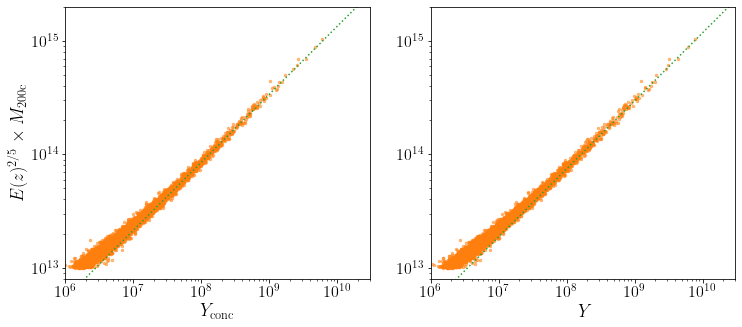

In [23]:
plt.figure(figsize=(12,5))
powlaw=np.logspace(-10,30,num=5);
#plt.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)

plt.subplot(121)
ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log'); 
ax.scatter(Y*(1-0.4*cGas),m200*1e10,alpha=.5,s=6,color='C1')
#ax.scatter(Y_r[:,101]-Y_r[:,50],m200*1e10,alpha=.5,s=6,color='C1')
#ax.scatter(Y*(1+.7*mStar/mGas-0.4*cGas)**(5/3),m200*1e10,alpha=.5,s=6,color='C1')
plt.ylim(8e12,2e15); plt.xlim(1e6,3e10)
plt.ylabel(r'$E(z)^{2/5} \times M_\mathrm{200c}$',fontsize=18); plt.xlabel(r'$Y_\mathrm{conc}$',fontsize=18)
ax.plot(powlaw,(powlaw**(3./5.))*1.35e9,ls='dotted',color='C2')

plt.subplot(122)
ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log'); 
ax.scatter(Y,m200*1e10,alpha=.5,s=6,color='C1')
ax.plot(powlaw,(powlaw**(3./5.))*1.18e9,ls='dotted',color='C2')
plt.ylim(8e12,2e15); plt.xlim(1e6,3e10)
plt.xlabel(r'$Y$',fontsize=18)

# Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import metrics

In [32]:
#Carving out a test set, which is a cube of size 175 Mpc/h within a 225 Mpc/h box
# Usually a test set is 20-30% of the total data but here I have chosen a large chunk 
# as I saw the RF trains efficiently with even a small dataset

boxLen=175.
maskTest=pos[:,0]<boxLen; maskTest*=pos[:,1]<boxLen; maskTest*=pos[:,2]<boxLen
Y2 = Y[maskTest]; m2002=m200[maskTest]

In [33]:
# Input array to RF
inp=np.zeros((len(m200),5))
inp[:,0]=Y; 
inp[:,1]=cNFW;
inp[:,2]=cGas;
inp[:,3]=mStar/mGas;
#inp[:,4]=nGal
out=m200*1e10/(Y**(3./5.)*1.234852304e9)

In [34]:
#Initializing RF
regr = RandomForestRegressor(max_depth=50, random_state=0,min_samples_leaf=5,n_estimators=50,n_jobs=-1)

#Fitting to training data
regr.fit(inp[~maskTest],out[~maskTest],sample_weight=pow(m200,1)[~maskTest])

#Importance given by RF to each feature
print(regr.feature_importances_)

metrics.mean_squared_error(regr.predict(inp[maskTest]),out[maskTest])

[0.63488555 0.0641     0.03951404 0.26150042 0.        ]


0.0061866996031068175

In [35]:
# Null test: training a RF only on Y
regr2 = RandomForestRegressor(max_depth=50, random_state=0,min_samples_leaf=5,n_estimators=50,n_jobs=-1)
regr2.fit(inp[~maskTest][:,0].reshape(-1,1),out[~maskTest],sample_weight=pow(m200,1.5)[~maskTest]);

metrics.mean_squared_error(regr2.predict(inp[maskTest][:,0].reshape(-1,1)),out[maskTest])

0.0084496208285947

In [36]:
# Calculating scatter in the mass prediction

mRatio0 = regr2.predict(inp[maskTest][:,0].reshape(-1,1))/out[maskTest]-1;
mRatio1 = regr.predict(inp[maskTest])/out[maskTest]-1;

temp=np.logspace(3.6,4.5,num=5);temp2=sqrt(temp[:-1]*temp[1:]); stdM0=temp2.copy(); stdM1=temp2.copy()

for i in range(len(temp)-1):
    mask=(m2002>=temp[i])*(m2002<=temp[i+1])
    stdM0[i]=np.std(mRatio0[mask]); stdM1[i]=np.std(mRatio1[mask]);

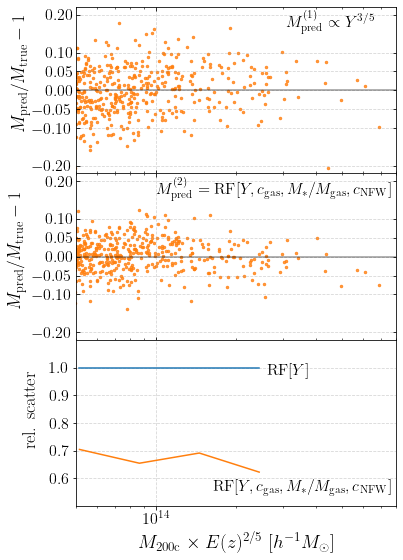

In [37]:
fig = plt.figure(num=None, figsize=(5.3, 7))
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

ax1 = fig.add_axes([0.15, 0.66, 0.84, 0.33], xlim=(5e13,8e14),ylim=(-0.22,0.22));
ax2 = fig.add_axes([0.15, 0.33, 0.84, 0.33], xlim=(5e13,8e14),ylim=(-0.22,0.22)); 
ax3 = fig.add_axes([0.15, 0.0, 0.84, 0.33], xlim=(5e13,8e14),ylim=(0.5,1.1)); 

ax1.set_yscale('linear'); ax1.set_xscale('log');
ax2.set_yscale('linear'); ax2.set_xscale('log'); 
ax1.set_yticks((-0.2,-0.1,-0.05,0,0.05,0.1,0.2));
ax2.set_yticks((-0.2,-0.1,-0.05,0,0.05,0.1,0.2)); #ax2.set_xticklabels(('0.06','0.1','0.3','1','2'))
ax3.set_yticks((0.6,0.7,0.8,0.9,1));
ax1.scatter(m200[maskTest]*1e10,(Y[maskTest]**(3./5.)*1.234852304e9)/(m200[maskTest]*1e10)-1.,alpha=.8,s=6,color='C1')
#ax1.legend([ 'IllustrisTNG',"HOD (Mass only)","HOD $*$ Eq. 6","RF (Mass, Env.)"], loc=4,fontsize=14)
ax1.tick_params(axis="both",direction="in",which='both',right='true',top='true', labelbottom=0)
ax1.axhline(y=0, color='black', linestyle='-',alpha=0.4)

ax2.scatter(m200[maskTest]*1e10,mRatio1,alpha=.8,s=6,color='C1')
ax2.tick_params(axis="both",direction="in",which='both',right='true',top='true', labelbottom=0)
ax2.axhline(y=0, color='black', linestyle='-',alpha=0.4)
ax3.semilogx(temp2*1e10,np.ones(len(temp2)))
ax3.semilogx(temp2*1e10,stdM1/stdM0)
#ax3.semilogx(temp2*1e10,stdM2/stdM0)
#ax3.semilogx(temp2*1e10,stdM3/stdM0)
#ax3.legend(["RF[$Y$]","RF[$Y,c_\mathrm{gas}$]","RF[$Y,c_\mathrm{gas},M_*/M_\mathrm{gas}$]","RF[$Y,c_\mathrm{gas},M_*/M_\mathrm{gas},c_{\,\mathrm{DM}}$]"], loc=2,fontsize=15)

ax1.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)
ax2.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)
ax3.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)

fig.text(0.7, 0.95, "$M^{(1)}_\mathrm{pred}\propto Y^{3/5}$", rotation=0,fontsize=16)
fig.text(0.36, 0.62, "$M^{(2)}_\mathrm{pred}=\mathrm{RF}[Y,c_\mathrm{gas},M_*/M_\mathrm{gas},c_\mathrm{NFW}]$", rotation=0,fontsize=16)
fig.text(-0.02, 0.75, r"$M_\mathrm{pred}/M_\mathrm{true} -1$", rotation=90,fontsize=18)
fig.text(-0.03, 0.4, r"$M_\mathrm{pred}/M_\mathrm{true} -1$", rotation=90,fontsize=18)
fig.text(0.01, 0.12, r"rel. scatter", rotation=90,fontsize=18)
fig.text(0.65, 0.26, "RF[$Y$]",fontsize=16)
# fig.text(0.65, 0.2, "RF[$Y,c_\mathrm{gas}$]",fontsize=16)
# fig.text(0.62, 0.11, "RF[$Y,c_\mathrm{gas},M_*/M_\mathrm{gas}$]",fontsize=16)
fig.text(0.51, 0.03, "RF[$Y,c_\mathrm{gas},M_*/M_\mathrm{gas},c_{\,\mathrm{NFW}}$]",fontsize=16)
plt.xlabel(r'$M_\mathrm{200c} \times E(z)^{2/5}\ [h^{-1} M_\odot]$',fontsize=19);
#plt.savefig(plotdir+'trash.pdf', bbox_inches='tight')

In [ ]:
# Extra code for using xgboost or GradientBoostingRegressor instead of RF
# replace the following with above code

# from sklearn.ensemble import GradientBoostingRegressor
# import xgboost as xgb

# regr = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 50, alpha = 10, n_estimators = 50)

# regr = GradientBoostingRegressor(max_depth=50, random_state=0,min_samples_leaf=5,n_estimators=50)

# Symbolic regression

In [ ]:
# We use the PySR package by Miles Cranmer: https://pysr.readthedocs.io/en/latest/

In [38]:
# Using a higher mass cutoff in order to reduce the number of data points for symbolic regression.
# and adding 'S' to denote the new arrays

mask=m200>5e3;
m200S=m200[mask];
YS=Y[mask]; mGasS=mGas[mask]; cGasS=cGas[mask]; 
cNFWS=cNFW[mask]; mStarS=mStar[mask];

EzS=Ez[mask]; #r200=r200[mask]; posS=pos[mask]

In [39]:
# As PySR requires a bit of time to run, I export the datafile and
# run PySR separately on terminal (the code is in the following cell)
# The output equations are tested further below

export=np.zeros((len(YS),5))
export[:,0]=m200S*1e10/(YS**(3./5.)*1e9);
export[:,1]=cGasS;
export[:,2]=mSG=mStarS/mGasS;
export[:,3]=1/cNFWS;
#export[:,4]=1.-.4*export[:,2];
export[:,4]=pow(m200S/1e4,0.5);

#np.save('.../SZ.npy',export)

In [40]:
# PySR code (run separately on a terminal window):

# import numpy as np
# from pysr import pysr

# a=np.load('.../SZ.npy')
# a.shape
# y = a[:,0]
# X = a[:,1:-1]
# weights=a[:,-1]
# varN=['cGas', 'mSG','cNFW'] #'Y'

# equations = pysr(X, y, niterations=5,
#             binary_operators=["plus", "mult", "pow","div"],
#             unary_operators=["neg","exp","log10_abs"], #'square'
#             weights=weights,
#             variable_names=(varN),
#             procs=4,
#             loss="L1DistLoss()",
#             equation_file='.../del.csv')
            
# print(equations['sympy_format'])

In [41]:
mRatio={}; numEqs=6

In [42]:
# Equations for Fig. 4 in main paper

mRatio[0]=YS**(3./5.)*1.234852304e9 # benchmark
mRatio[1]=YS**(3./5.)*1.48e9*(1.-.4*cGasS) 
mRatio[2]=YS**(3./5.)*1.e9*pow(1 / 0.020132495/cNFWS, mSG * 0.996002)

In [43]:
# Equations for Fig. 10 in appendix 

mRatio[3]=YS**(3./5.)*1.e9*pow(cGasS, -0.233)
mRatio[4]=YS**(3./5.)*1.38e9*(1.-.4*cGasS+.7*mSG)# mStar/mGas
mRatio[5]=YS**(3./5.)*1.e9*(exp(0.69271135 /cNFWS) + mSG)

#mRatio[6]=YS**(.62)*(1.-.6*cGasS)*1.12e9 # The case in Fig.9 when the slope is diff from 3/5
#mRatio[7]=YS**(3./5.)*1.e9*(mSG + pow(2.2547657 / (GasConcS + (2.4132502 * mSG)), mSG))

In [44]:
# Normalizing

for i in range(numEqs):
    mRatio[i]=mRatio[i]/(m200S*1e10) -1

In [45]:
# meanM is the mean deviation and stdM is the scatter value

temp=np.logspace(3.6,4.5,num=5);

meanM=np.zeros((numEqs,len(temp)-1)); temp2=np.zeros(len(temp)-1)

pltSct=sqrt(temp[:-1]*temp[1:]);

stdM={}
for j in range(numEqs):
    for i in range(len(temp)-1):
        mask=(m200S>=temp[i])*(m200S<=temp[i+1])
        meanM[j,i]=np.mean(mRatio[j][mask]); temp2[i]=np.std(mRatio[j][mask]);
    stdM[j]=temp2.copy()

print(meanM)

[[-0.01130987 -0.00145983  0.0114293   0.01509859]
 [ 0.00172834 -0.00564651 -0.0118968  -0.02587104]
 [ 0.00554946  0.00327888  0.00063058 -0.01801968]
 [ 0.00103979 -0.00977802 -0.01731774 -0.03159212]
 [ 0.01813835  0.00530003 -0.00605811 -0.0269176 ]
 [-0.01080104 -0.00062841  0.01073351  0.00090437]]


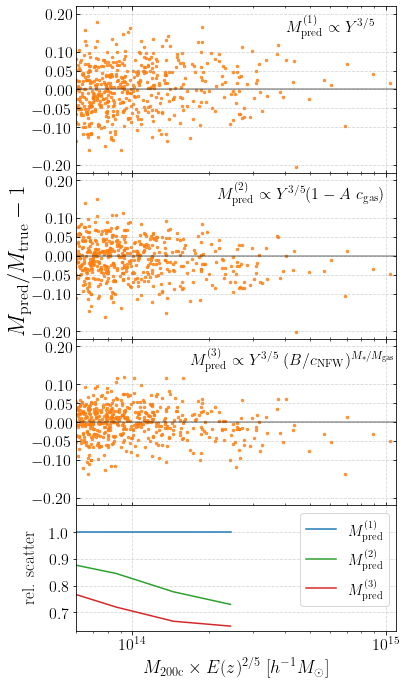

In [46]:
fig = plt.figure(num=None, figsize=(5.3, 7))
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

ax1 = fig.add_axes([0.15, 0.91, 0.84, 0.33], xlim=(6e13,1.1e15),ylim=(-0.22,0.22));
ax2 = fig.add_axes([0.15, 0.58, 0.84, 0.33], xlim=(6e13,1.1e15),ylim=(-0.22,0.22)); 
ax3 = fig.add_axes([0.15, 0.25, 0.84, 0.33], xlim=(6e13,1.1e15),ylim=(-0.22,0.22)); 
ax4 = fig.add_axes([0.15, 0.0, 0.84, 0.25], xlim=(6e13,1.1e15),ylim=(0.63,1.1));

ax1.set_xscale('log'); ax2.set_xscale('log'); ax3.set_xscale('log');
ax1.set_yticks((-0.2,-0.1,-0.05,0,0.05,0.1,0.2));
ax2.set_yticks((-0.2,-0.1,-0.05,0,0.05,0.1,0.2)); #ax2.set_xticklabels(('0.06','0.1','0.3','1','2'))
ax3.set_yticks((-0.2,-0.1,-0.05,0,0.05,0.1,0.2));
ax4.set_yticks((0.7,0.8,0.9,1));
ax1.scatter(m200S*1e10,(YS**(3./5.)*1.234852304e9)/(m200S*1e10)-1.,alpha=.8,s=6,color='C1')
ax1.tick_params(axis="both",direction="in",which='both',right='true',top='true', labelbottom=0)
ax1.axhline(y=0, color='black', linestyle='-',alpha=0.4)

ax2.scatter(m200S*1e10,mRatio[1],alpha=.8,s=6,color='C1')
ax2.tick_params(axis="both",direction="in",which='both',right='true',top='true', labelbottom=0)
ax2.axhline(y=0, color='black', linestyle='-',alpha=0.4)
ax3.scatter(m200S*1e10,mRatio[2],alpha=.8,s=6,color='C1')
ax3.tick_params(axis="both",direction="in",which='both',right='true',top='true', labelbottom=0)
ax3.axhline(y=0, color='black', linestyle='-',alpha=0.4)
ax4.semilogx(pltSct*1e10,np.ones(len(pltSct)))
ax4.semilogx(pltSct*1e10,stdM[1]/stdM[0],color='C2')
ax4.semilogx(pltSct*1e10,stdM[2]/stdM[0],color='C3')
ax4.legend([ "$M^{(1)}_\mathrm{pred}$","$M^{(2)}_\mathrm{pred}$","$M^{(3)}_\mathrm{pred}$"], loc=1,fontsize=15)


ax1.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)
ax2.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)
ax3.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)
ax4.grid(b=True, which='major', color='#999999', linestyle='--',alpha=0.4)

fig.text(0.7, 1.19, "$M^{(1)}_\mathrm{pred}\propto Y^{3/5}$", rotation=0,fontsize=16)
fig.text(0.52, 0.86, "$M^{(2)}_\mathrm{pred}\propto Y^{3/5} (1-A\ c_\mathrm{gas})$", rotation=0,fontsize=16)
fig.text(0.45, 0.53, "$M^{(3)}_\mathrm{pred}\propto Y^{3/5}\ (B/c_\mathrm{NFW})^{M_*/M_\mathrm{gas}}$", rotation=0,fontsize=16)
fig.text(-0.03, 0.6, r"$M_\mathrm{pred}/M_\mathrm{true} -1$", rotation=90,fontsize=23)
#fig.text(0.0, 0.4, r"$M_\mathrm{pred}/M_\mathrm{true} -1$", rotation=90,fontsize=18)
fig.text(0.01, 0.06, r"rel. scatter", rotation=90,fontsize=17)
plt.xlabel(r'$ M_\mathrm{200c} \times E(z)^{2/5}\ [h^{-1} M_\odot]$');
#plt.savefig(plotdir+'trash.pdf', bbox_inches='tight')

# Extras

In [ ]:
# This section is for calculating halo properties from the TNG300 simulation

# This section is unfinished as of now

In [142]:
import illustris_python as il

In [ ]:
basePath = '/data/jayw/CCA/Data/TNG_website/TNG300-1/z_0.0'

In [ ]:
m200=il.groupcat.loadHalos(basePath,99,fields='Group_M_Crit200')
maskMass=m200>1e3;

In [141]:
# Sum of BH masses
BH=il.groupcat.loadHalos(basePath,99,fields='GroupBHMass')
BH=BH[maskMass]

NameError: name 'il' is not defined

In [ ]:
#Generating halo catalogs
#Group_M_Crit200, GroupBHMass, GroupNsubs, GroupMass, Group_M_Crit200, ,'GroupPos', 'Group_R_Crit200', 'GroupFirstSub','GroupMassType'
data=il.groupcat.loadHalos(basePath,99,fields='GroupPos')
#mMean= data['Group_M_Mean200']
#m200= data
#BH = data
#BHdot = data['GroupBHMdot']
#sfr = data['GroupSFR']
#metallicity = data['GroupGasMetallicity']
#mGas=data['GroupMassType'][:,0]
pos=data/1e3;
#r200=data/1e3
#FirstSub= data['GroupFirstSub']

In [ ]:
# For calculating ellipticity

qRFile= np.load('LessImp/Tij_gas_DM_stars_BHs.npy');
#qRFile= np.load('Tij_gas.npy');
shear=(qRFile[:,0]/qRFile[:,2])
#shear=(qRFile[:,2]-qRFile[:,0])/2/(qRFile[:,0]+qRFile[:,1]+qRFile[:,2])